In [1]:
import psycopg2
import datetime as dt
from dateutil.relativedelta import relativedelta
from parser_opennem import parse_request_json
from db_populate import insert_batch
from dateutil.relativedelta import relativedelta
import pandas as pd
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'parser_opennem'

In [2]:
db_name = "energy"
db_user = "dawki"
db_pword_file = "C:\\Users\\dawki\\OneDrive\\Archive\\2019\\Documents\\private.txt"
with open(db_pword_file) as f:
    db_pword = f.read()

In [3]:
## Connect to DB
dbc = psycopg2.connect(user=db_user,
                        password=db_pword,
                        host="127.0.0.1",
                        port="5432",
                        database=db_name)
cursor = dbc.cursor()

In [4]:
# Rquest all NSW power data
cursor.execute(
    f"select interval_start, dim_region.code as region, dim_fueltech.long_name as fueltech, power \
    from fact_power, dim_batch, dim_fueltech, dim_region \
    where dim_batch.id=batch_id AND fueltech_id=dim_fueltech.id AND dim_region.id = region_id AND dim_region.code = 'NSW1'"
)
nsw_power = cursor.fetchall()

In [49]:
nsw_power_df = pd.DataFrame(nsw_power, columns=["interval_start","region","fueltech","power"])

In [53]:
nsw_power_df.set_index("interval_start")

,region,fueltech,power
interval_start,,,
2019-01-01 00:00:00,NSW1,gas_ocgt,0.00000
2019-01-01 00:00:00,NSW1,solar_utility,0.29300
2019-01-01 00:00:00,NSW1,distillate,-0.02039
2019-01-01 00:00:00,NSW1,gas_ccgt,0.14380
2019-01-01 00:00:00,NSW1,hydro,71.21000
...,...,...,...
2021-08-31 23:55:00,NSW1,gas_ccgt,284.10000
2021-08-31 23:55:00,NSW1,hydro,56.44000
2021-08-31 23:55:00,NSW1,coal_black,6827.00000


In [58]:
def fueltech_df(power_df,ft):
    new_df = power_df.loc[power_df.fueltech==ft]
    new_df.loc[:,"rolling_avg_power_month"] = new_df.loc[:,"power"].rolling(window=48*31).mean()
    new_df.loc[:,"rolling_avg_power_week"] = new_df.loc[:,"power"].rolling(window=48*7).mean()
    new_df.loc[:,"rolling_avg_power_day"] = new_df.loc[:,"power"].rolling(window=48).mean()
    new_df = new_df.set_index("interval_start")
    return new_df

In [59]:
fueltech_dfs = {x:fueltech_df(nsw_power_df,x) for x in nsw_power_df.fueltech.unique()} 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [60]:
fueltech_dfs['gas_ocgt']

,region,fueltech,power,rolling_avg_power_month,rolling_avg_power_week,rolling_avg_power_day
interval_start,,,,,,
2019-01-01 00:00:00,NSW1,gas_ocgt,0.0,NaN,NaN,NaN
2019-01-01 00:05:00,NSW1,gas_ocgt,0.0,NaN,NaN,NaN
2019-01-01 00:10:00,NSW1,gas_ocgt,0.0,NaN,NaN,NaN
2019-01-01 00:15:00,NSW1,gas_ocgt,0.0,NaN,NaN,NaN
2019-01-01 00:20:00,NSW1,gas_ocgt,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-08-31 23:35:00,NSW1,gas_ocgt,0.0,52.582917,11.773006,7.105427e-15
2021-08-31 23:40:00,NSW1,gas_ocgt,0.0,52.135605,10.784315,7.105427e-15
2021-08-31 23:45:00,NSW1,gas_ocgt,0.0,51.688629,9.795625,7.105427e-15


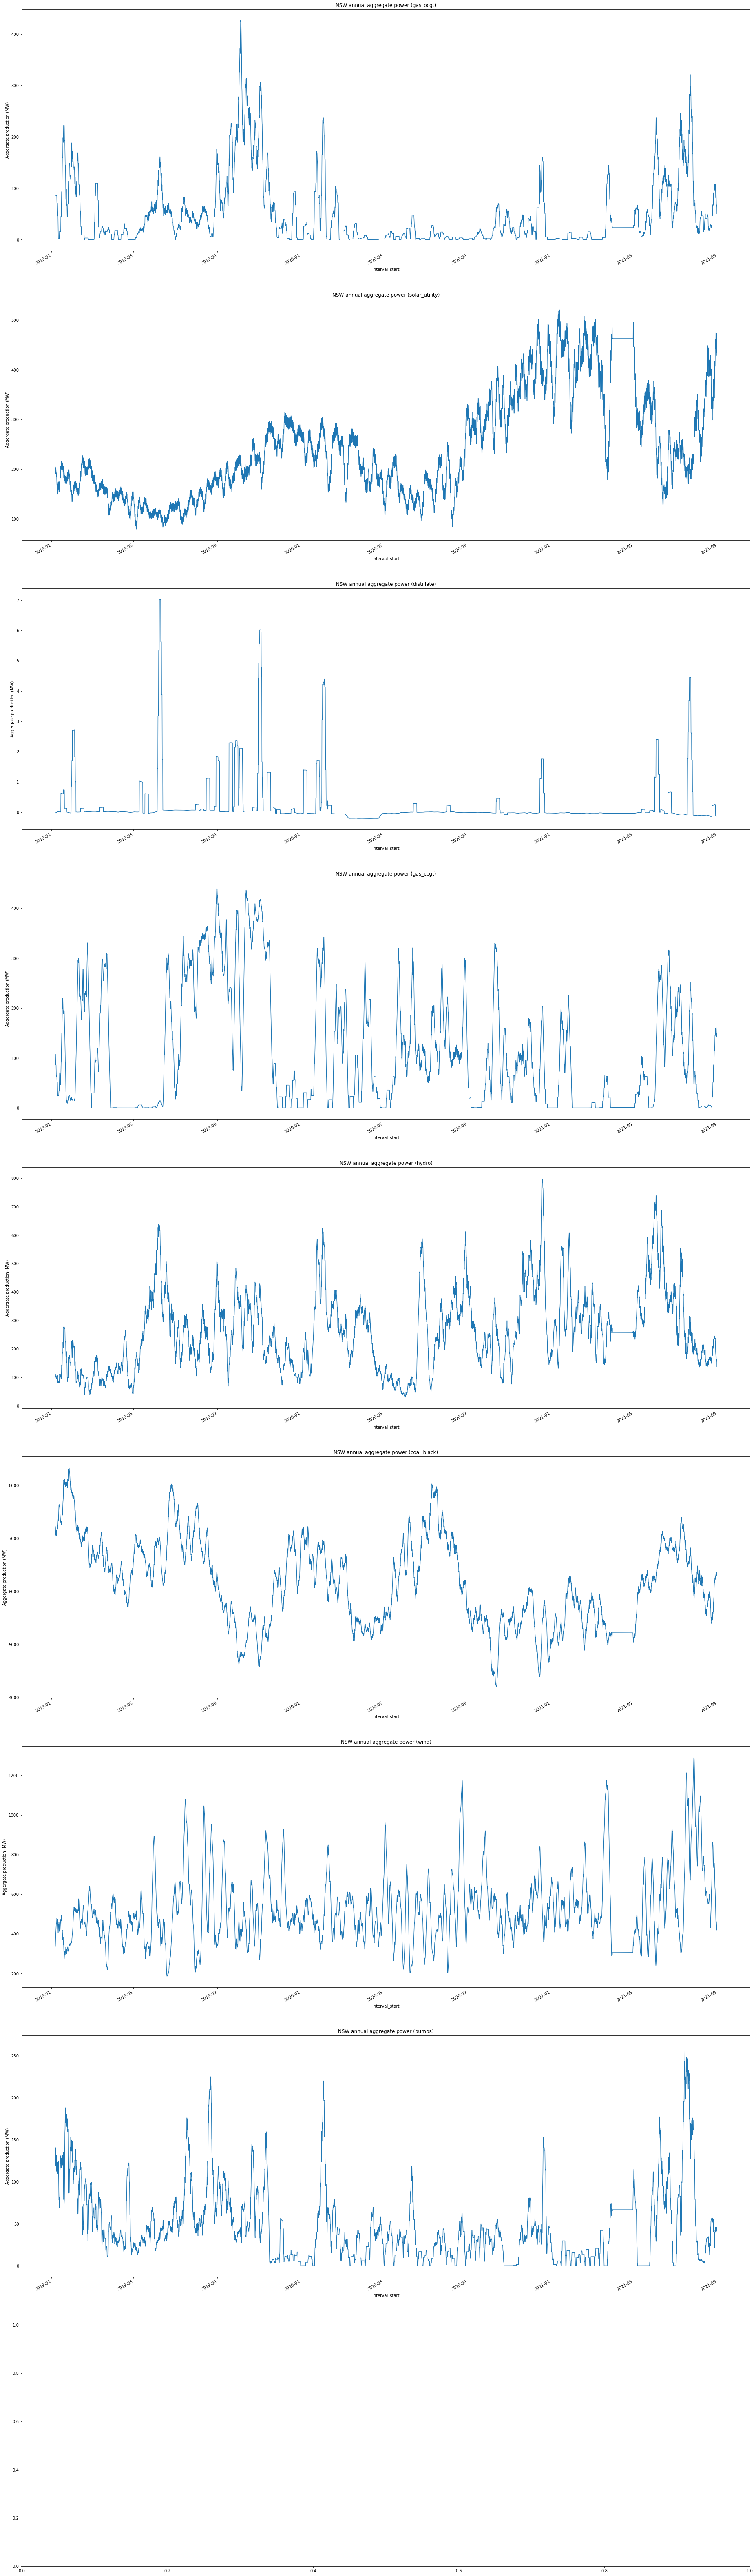

In [65]:
fig, ax = plt.subplots(9,figsize=(32,16*8))
for i,(ft,ft_df) in enumerate(fueltech_dfs.items()):
    ft_df.loc[:,"rolling_avg_power_month"].plot(ax=ax[i])
    ax[i].set_title(f'NSW annual aggregate power ({ft})')
    ax[i].set_ylabel('Aggergate production (MW)')



In [ ]:
fig, ax = plt.subplots(figsize=(32,16))
ax.set_title('NSW annual aggregate power by fuel type')
ax.set_ylabel('Aggergate production (MW)')
for ft_df in fueltech_dfs.values():
    ft_df.loc[:,"rolling_avg_power_month"].plot(ax=ax)
plt.legend(fueltech_dfs.keys())

In [14]:
nsw_power_df = pd.DataFrame(nsw_power, columns=["interval_start","region","fueltech","power"])
nsw_aggregate_power_df = nsw_power_df.groupby(["interval_start"]).sum()

# rolling average
nsw_aggregate_power_df["rolling_avg_power_month"] = nsw_aggregate_power_df["power"].rolling(window=48*31).mean()
nsw_aggregate_power_df["rolling_avg_power_week"] = nsw_aggregate_power_df["power"].rolling(window=48*7).mean()
nsw_aggregate_power_df["rolling_avg_power_day"] = nsw_aggregate_power_df["power"].rolling(window=48).mean()

In [15]:
fueltech_dfs

{'gas_ocgt':              interval_start region  fueltech  power
 0       2019-01-01 00:00:00   NSW1  gas_ocgt    0.0
 8       2019-01-01 00:05:00   NSW1  gas_ocgt    0.0
 16      2019-01-01 00:10:00   NSW1  gas_ocgt    0.0
 24      2019-01-01 00:15:00   NSW1  gas_ocgt    0.0
 32      2019-01-01 00:20:00   NSW1  gas_ocgt    0.0
 ...                     ...    ...       ...    ...
 2174936 2021-08-31 23:35:00   NSW1  gas_ocgt    0.0
 2174944 2021-08-31 23:40:00   NSW1  gas_ocgt    0.0
 2174952 2021-08-31 23:45:00   NSW1  gas_ocgt    0.0
 2174960 2021-08-31 23:50:00   NSW1  gas_ocgt    0.0
 2174968 2021-08-31 23:55:00   NSW1  gas_ocgt    0.0
 
 [271872 rows x 4 columns],
 'solar_utility':              interval_start region       fueltech  power
 1       2019-01-01 00:00:00   NSW1  solar_utility  0.293
 9       2019-01-01 00:05:00   NSW1  solar_utility  0.293
 17      2019-01-01 00:10:00   NSW1  solar_utility  0.293
 25      2019-01-01 00:15:00   NSW1  solar_utility  0.293
 33      2019-0

# Long run aggregate 

<AxesSubplot:title={'center':'NSW long run aggregate power'}, xlabel='interval_start', ylabel='Aggergate production (MW)'>

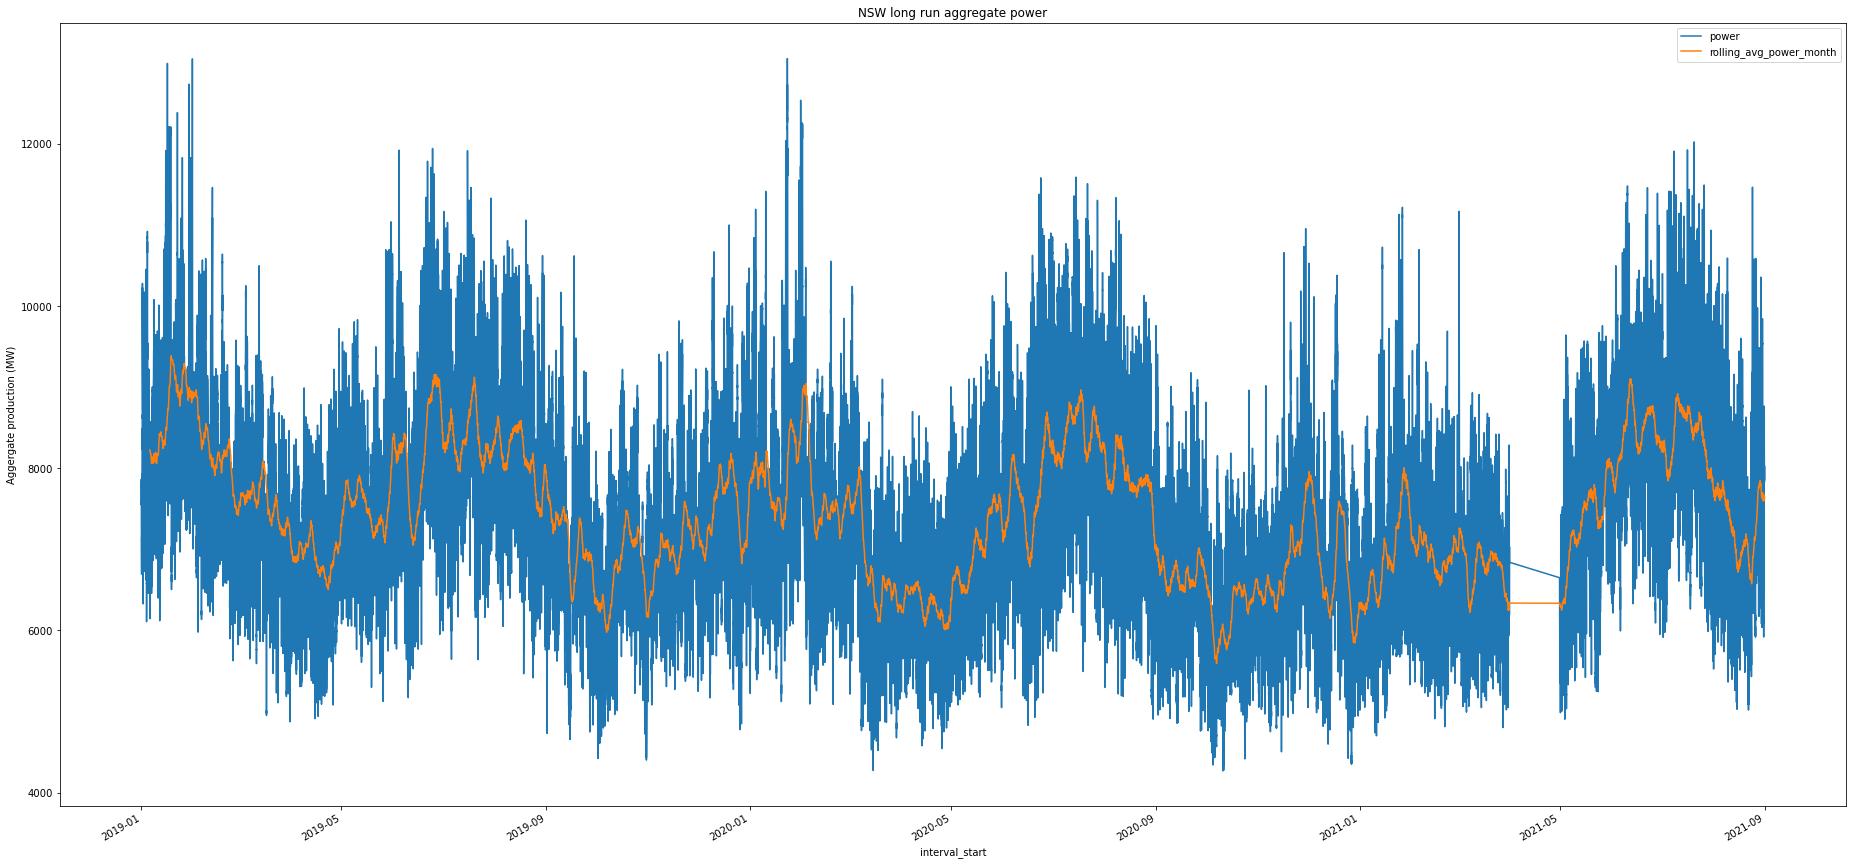

In [17]:
fig, ax = plt.subplots(figsize=(32,16))
ax.set_title('NSW long run aggregate power')
ax.set_ylabel('Aggergate production (MW)')
nsw_aggregate_power_df[["power","rolling_avg_power_month"]].plot(ax=ax)


# Year

<AxesSubplot:title={'center':'NSW long run aggregate power'}, xlabel='interval_start', ylabel='Aggergate production (MW)'>

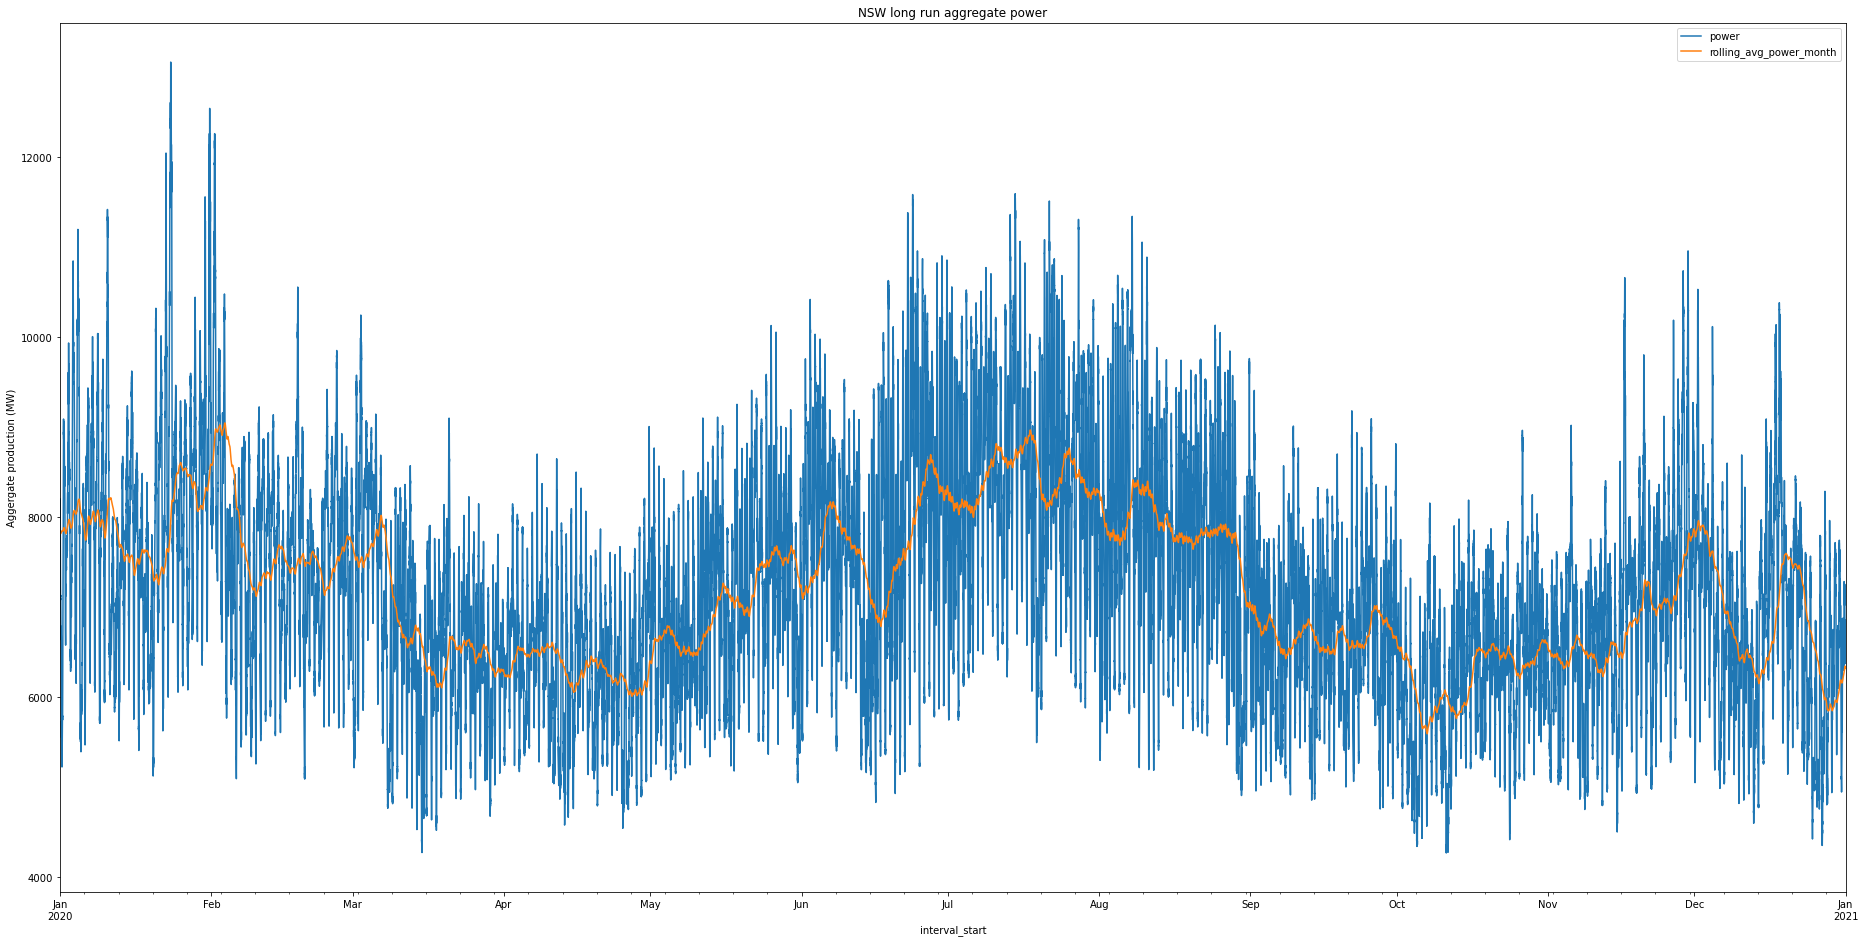

In [18]:
fig, ax = plt.subplots(figsize=(32,16))
ax.set_title('NSW long run aggregate power')
ax.set_ylabel('Aggergate production (MW)')
nsw_aggregate_power_df[["power","rolling_avg_power_month"]][(nsw_aggregate_power_df.index >= '2020-01-01') & (nsw_aggregate_power_df.index <= '2021-01-01')].plot(ax=ax)

# Month

<AxesSubplot:title={'center':'NSW long run aggregate power'}, xlabel='interval_start', ylabel='Aggergate production (MW)'>

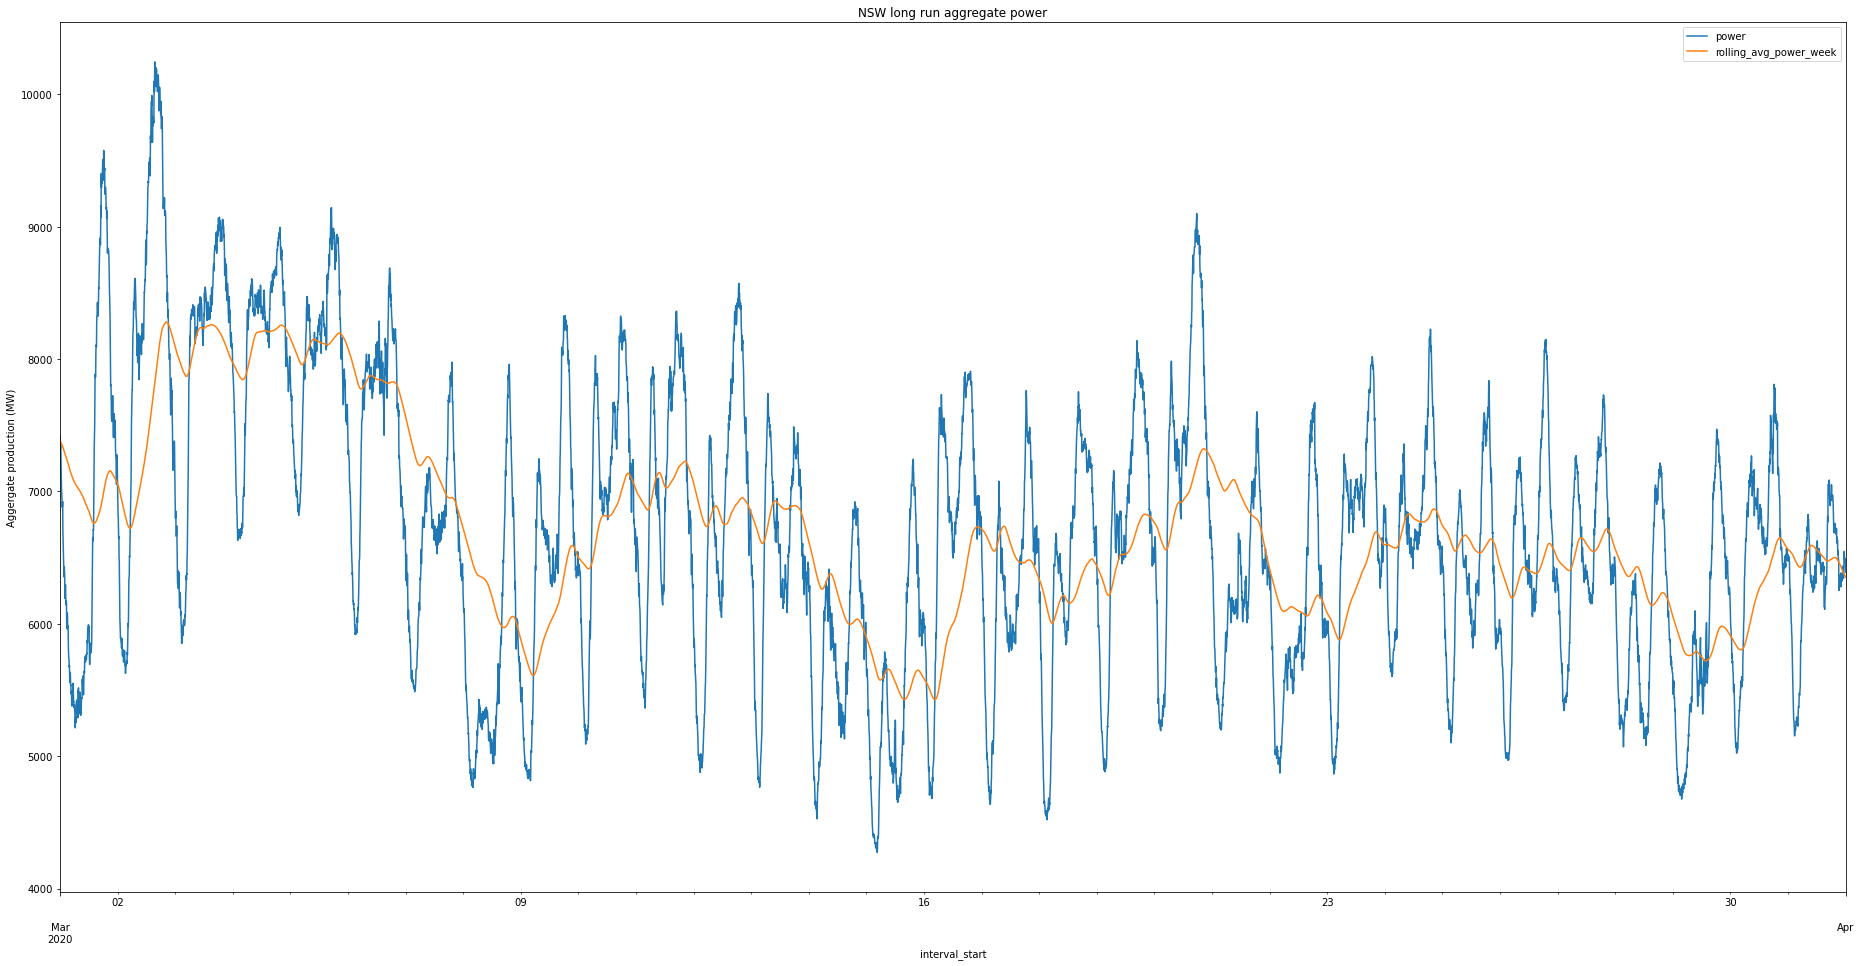

In [22]:
fig, ax = plt.subplots(figsize=(32,16))
ax.set_title('NSW long run aggregate power')
ax.set_ylabel('Aggergate production (MW)')
nsw_aggregate_power_df[["power","rolling_avg_power_week"]][(nsw_aggregate_power_df.index >= '2020-03-01') & (nsw_aggregate_power_df.index <= '2020-04-01')].plot(ax=ax)

# Week

<AxesSubplot:title={'center':'NSW long run aggregate power'}, xlabel='interval_start', ylabel='Aggergate production (MW)'>

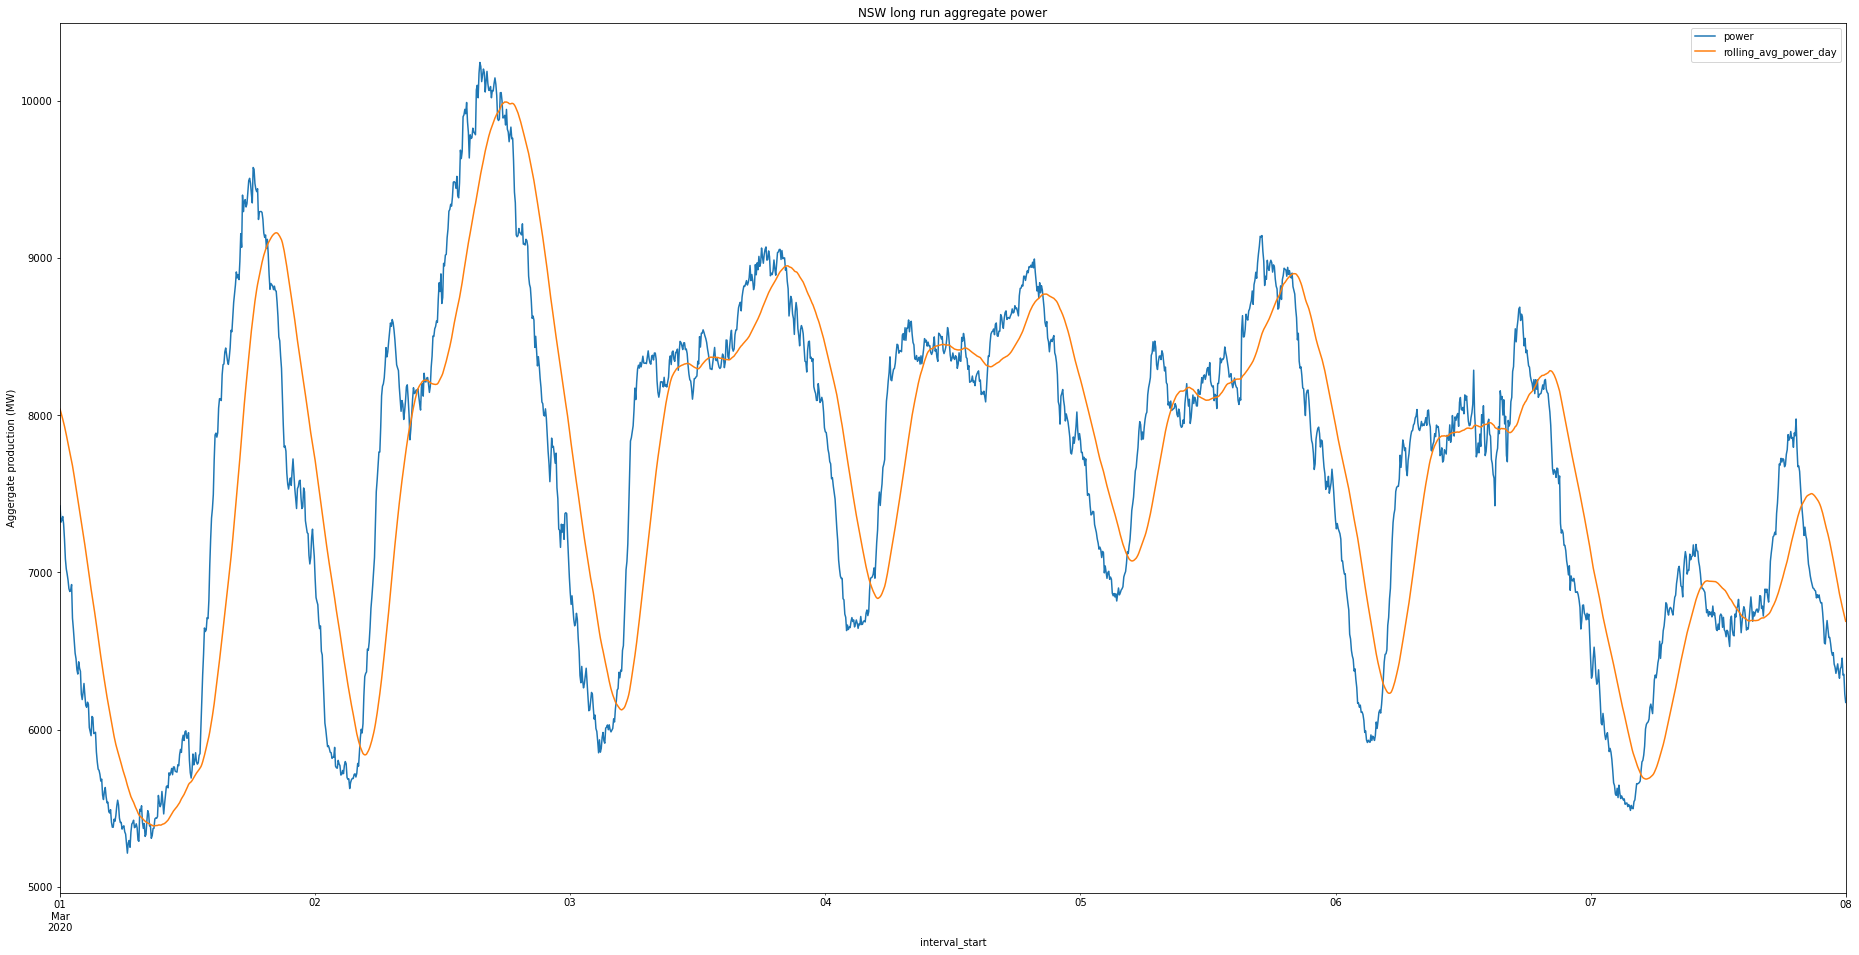

In [20]:
fig, ax = plt.subplots(figsize=(32,16))
ax.set_title('NSW long run aggregate power')
ax.set_ylabel('Aggergate production (MW)')
nsw_aggregate_power_df[["power","rolling_avg_power_day"]][(nsw_aggregate_power_df.index >= '2020-03-01') & (nsw_aggregate_power_df.index <= '2020-03-08')].plot(ax=ax)

# Day

<AxesSubplot:title={'center':'NSW long run aggregate power'}, xlabel='interval_start', ylabel='Aggergate production (MW)'>

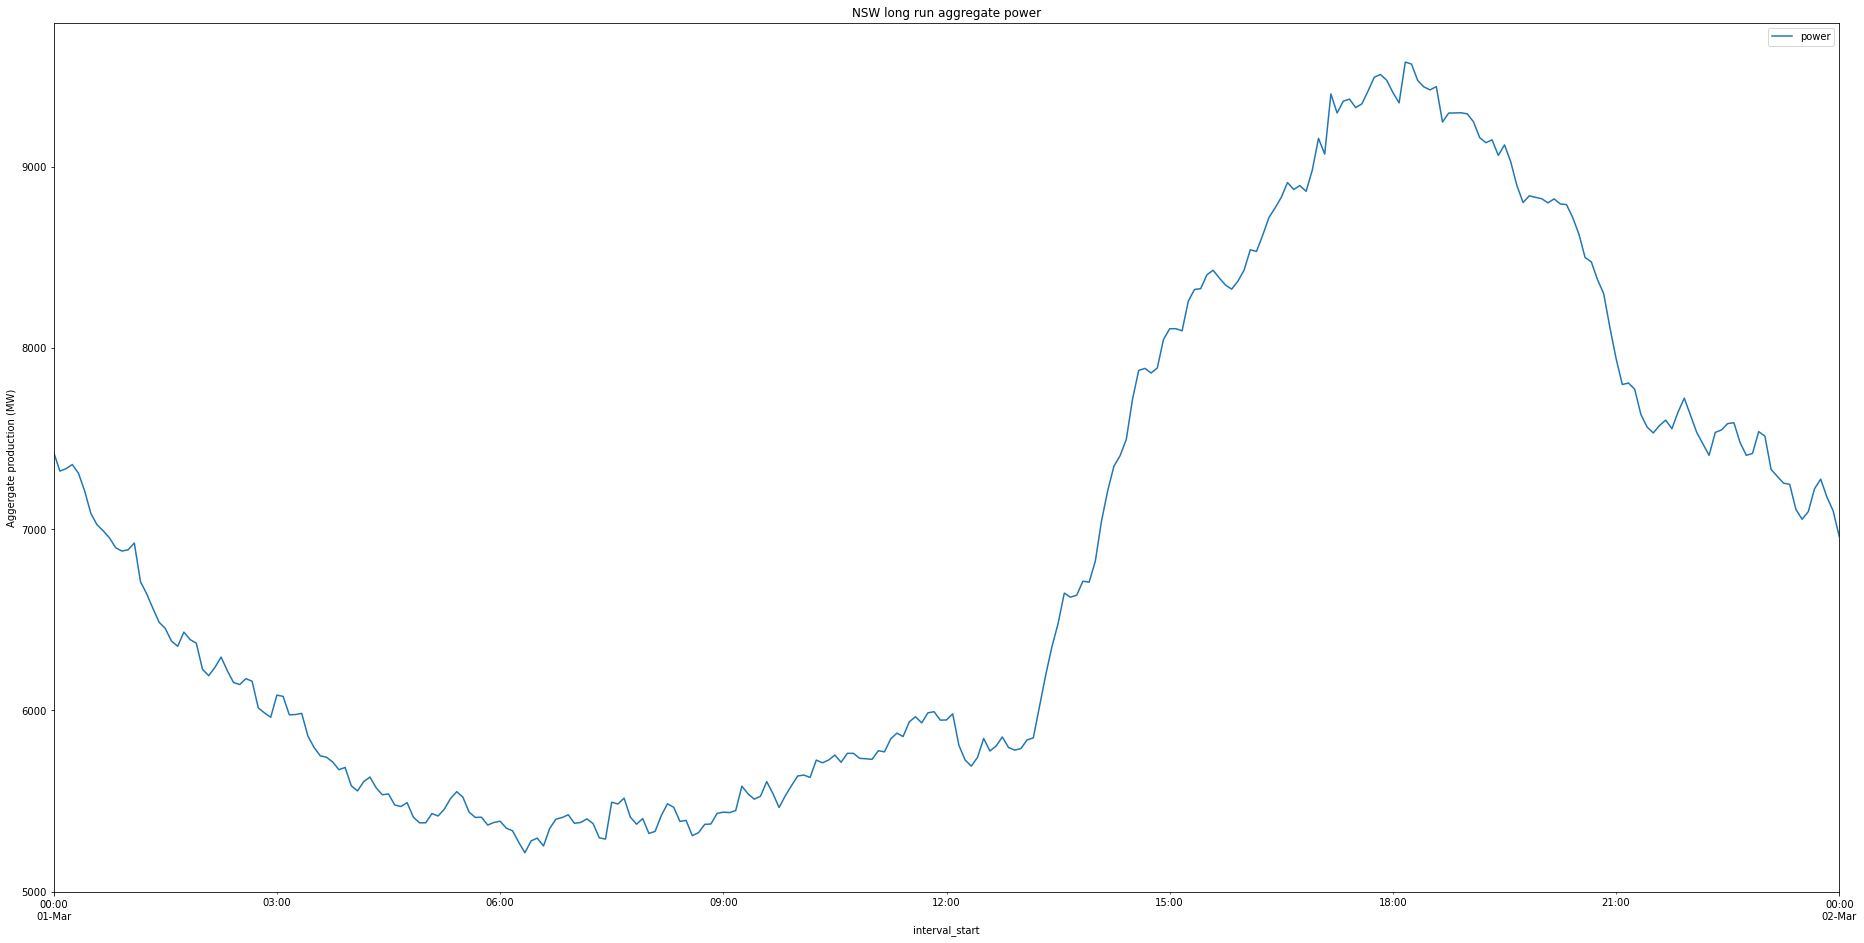

In [75]:
fig, ax = plt.subplots(figsize=(32,16))
ax.set_title('NSW long run aggregate power')
ax.set_ylabel('Aggergate production (MW)')
nsw_aggregate_power_df[(nsw_aggregate_power_df.index >= '2020-03-01') & (nsw_aggregate_power_df.index <= '2020-03-02')].plot(ax=ax)